# Super tutuł

Import wymaganych bilbiotek, sprawdzenie GPU

In [175]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import shutil, random
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Globalne zmienne

In [176]:
# Ścieżka z folderem z danymi
data_path = os.path.join(os.getcwd(), 'data')
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')
valid_path = os.path.join(data_path, 'valid')

# rozmiar docelowy zdjęć
image_size = 64
# jakies grupy TODO
batch_size = 32

#klasy takie jak nazwy folderów
classes = os.listdir(train_path)

#ile % zdjęć ma byc przeniesionych do folderu zawierającego zdj walidujące
validation_split_dataset = 0.1

# Liczba epok
epochs = 25

Wybranie obrazów walidujących.

Rozwiązanie problemu:
```python
ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'tensorflow.python.keras.preprocessing.image.DirectoryIterator'>]
```

In [177]:
if os.path.isdir(valid_path) is False:
    os.makedirs(valid_path)
    for class_dir in os.listdir(train_path):
        print('=', end='')
        src_dir = os.path.join(train_path, class_dir)
        dest_dir = os.path.join(valid_path, class_dir)
        os.makedirs(dest_dir)        
        elementy_w_folderze = os.listdir(src_dir)
        ile_elementow = len(elementy_w_folderze) 
        for i in random.sample(range(0, ile_elementow), int(ile_elementow*validation_split_dataset)):
            shutil.move(os.path.join(src_dir, elementy_w_folderze[i]) , dest_dir)
        
            

Wczytywanie obrazów

In [178]:
train_batches = ImageDataGenerator() \
    .flow_from_directory(directory=train_path, target_size=(image_size, image_size), classes=classes, batch_size=batch_size)
    
valid_batches = ImageDataGenerator() \
    .flow_from_directory(directory=valid_path, target_size=(image_size, image_size), classes=classes, batch_size=batch_size)
    
test_batches = ImageDataGenerator() \
    .flow_from_directory(directory=test_path, target_size=(image_size, image_size), classes=classes, batch_size=batch_size, shuffle=False)

Found 15116 images belonging to 92 classes.
Found 1630 images belonging to 92 classes.
Found 4298 images belonging to 92 classes.


Nwm co to rb

In [179]:
imgs, labels = next(train_batches)

Pokaż zdjęcia

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

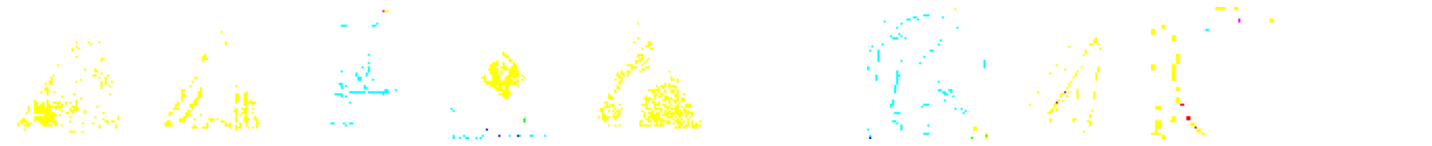

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [180]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(imgs)
print(labels)
    

Budowanie modelu

In [181]:
#Building the model
model = Sequential() # sequelntial otrzymuje dane kiedy wywołujemy funkcję celu na niej

model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=len(classes), activation='softmax'))
#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 60, 60, 32)        2432      
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 26, 26, 64)        18496     
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 12, 12, 64)      

Trenowanie

In [182]:
anc = model.fit(x=train_batches, batch_size=batch_size, epochs=epochs, validation_data=valid_batches)

Epoch 1/25
473/473 [==============================] - 23s 47ms/step - loss: 2.1478 - accuracy: 0.6216 - val_loss: 0.4397 - val_accuracy: 0.9129
Epoch 2/25
473/473 [==============================] - 25s 53ms/step - loss: 0.5306 - accuracy: 0.8687 - val_loss: 0.2002 - val_accuracy: 0.9552
Epoch 3/25
473/473 [==============================] - 27s 57ms/step - loss: 0.3655 - accuracy: 0.9099 - val_loss: 0.2029 - val_accuracy: 0.9515
Epoch 4/25
473/473 [==============================] - 25s 53ms/step - loss: 0.2651 - accuracy: 0.9326 - val_loss: 0.1913 - val_accuracy: 0.9571
Epoch 5/25
473/473 [==============================] - 27s 56ms/step - loss: 0.2209 - accuracy: 0.9452 - val_loss: 0.1361 - val_accuracy: 0.9718
Epoch 6/25
473/473 [==============================] - 26s 56ms/step - loss: 0.2025 - accuracy: 0.9486 - val_loss: 0.1422 - val_accuracy: 0.9736
Epoch 7/25
473/473 [==============================] - 26s 55ms/step - loss: 0.1684 - accuracy: 0.9569 - val_loss: 0.1797 - val_accuracy:

Zapis modelu do pliku

In [183]:
model.save('traffic_classifier.h5')

Statystyki wytrenowanego modelu

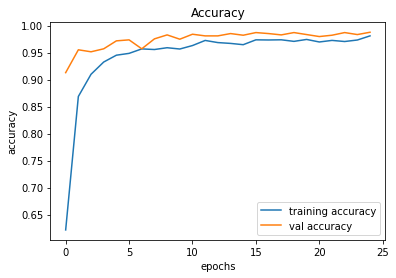

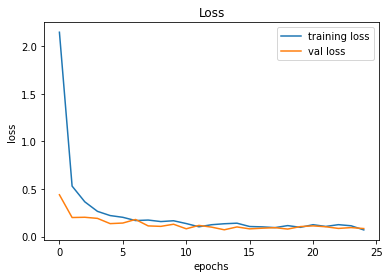

In [184]:
plt.figure(0)
plt.plot(anc.history['accuracy'], label='training accuracy')
plt.plot(anc.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(anc.history['loss'], label='training loss')
plt.plot(anc.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Predykcja

In [185]:
score = model.evaluate(test_batches, verbose = 1) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

135/135 [==============================] - 5s 34ms/step - loss: 0.2393 - accuracy: 0.9567
Test loss: 0.23932944238185883
Test accuracy: 0.9567240476608276


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

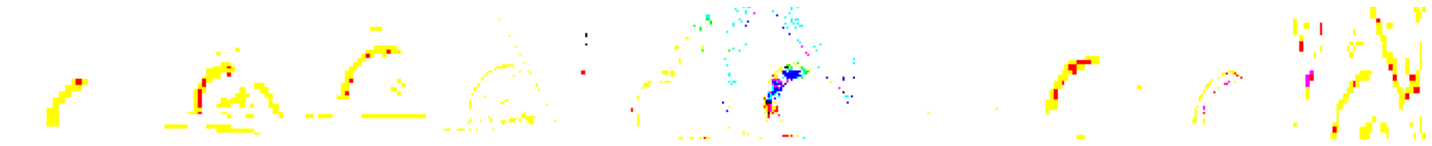

array([ 0,  0,  0, ..., 91, 91, 91])

In [186]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
#print(test_labels)
test_batches.classes

Macierz pokazująca na osiach dane tesujące i predykcję

Przekątna macierzy wskazuje dopasowanie tj predykcja poprawnie przewiduje

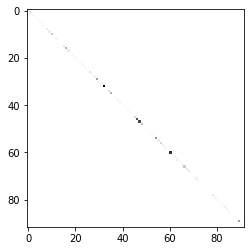

In [187]:
predictions = model.predict(x=test_batches)
np.round(predictions)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=predictions.argmax(axis=-1))
plt.imshow(cm, cmap='Greys',  interpolation='nearest')


In [188]:
def plot_confusion_matrix(cm, classes, normalize = False, title='Confusion matrix', cmap = plt.cm.Blues):
    classes = range(len(classes))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_title = "Normalized confusion matrix"
    else:
        cm_title = title
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(cm_title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.tight_layout()
    
    
#plot_confusion_matrix(cm, classes)


Otwierzanie modelu

In [189]:
from tensorflow.keras.models import load_model
model = load_model('traffic_classifier.h5')